# Семантическая сегментация (Semantic segmentation)

*Сегментация изображения — задача поиска групп пикселей, каждая из которых характеризует один смысловой объект.*

Технически это выглядит так. Есть набор изображений:


<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_segmentation_1.png" width="300">

Для каждого изображения есть маска $W × H$:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_segmentation_2.png" width="300">

Маска задает класс объекта для каждого пикселя:
[$(x,y) \to$ `class_num`]

Набор таких изображений с масками — это и есть наш датасет, на нем мы учимся.

На вход модель получает новое изображение:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_segmentation_3.png" width="600">

И должна предсказать метку класса для каждого пикселя (маску).

Получим такую маску из COCO:

In [1]:
# !wget -qN "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget -qN "https://ml.gan4x4.ru/msu/datasets/annotations_trainval2017.zip"
!unzip -qn annotations_trainval2017.zip

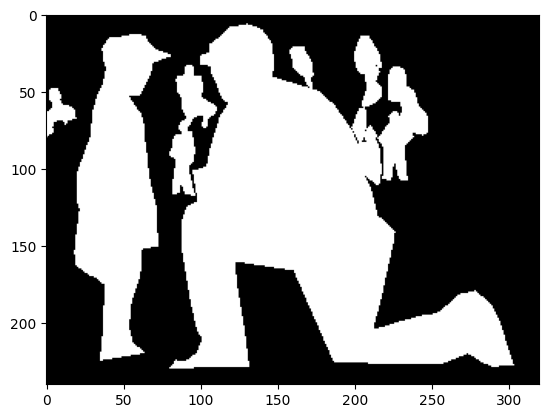

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from pycocotools.coco import COCO
from IPython.display import clear_output


def coco2pil(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


coco = COCO("annotations/instances_val2017.json")
clear_output()

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
img = coco.loadImgs(anns[0]["image_id"])[0]
I = coco2pil(img["coco_url"])

semantic_seg_person_mask = np.zeros(I.size[::-1], dtype=bool)  # WxH -> HxW

for ann in anns:
    msk = coco.annToMask(ann)  # HxW
    if ann["category_id"] == 1 and not ann["iscrowd"]:  # single person:
        # semantic_seg_person_mask = msk | semantic_seg_person_mask  # union
        semantic_seg_person_mask += msk.astype(bool)

semantic_seg_person_mask = semantic_seg_person_mask > 0  # binarize
plt.imshow(semantic_seg_person_mask, cmap="gray")
plt.show()

## Способы предсказания класса для каждого пикселя

Давайте подумаем о том, как такую задачу можно решить.

Из самой постановки задачи видно, что это задача классификации. Только не
всего изображения, а каждого пикселя.

**a) Наивный**




Простейшим вариантом решения является использование так называемого "скользящего окна" — последовательное рассмотрение фрагментов изображения. В данном случае интересующими фрагментами будут небольшие зоны, окружающие каждый из пикселей изображения. К каждому из таких фрагментов применяется свёрточная нейронная сеть, предсказывающая, к какому классу относится центральный пиксель.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/naive_way_predict_pixel_class.png" width="600">

**б) Разумный**

Понятно, что запускать классификатор для каждого пикселя абсолютно неэффективно, так как для одного изображения потребуется $H*W$ запусков.

Можно пойти другим путем: получить карту признаков и по ней делать предсказание для всех пикселей разом.

Для этого потребуется поменять привычную нам архитектуру сверточной сети следующим образом:

* убрать слои, уменьшающие пространственные размеры;
* убрать линейный слой в конце, заменив его сверточным.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/reasonable_way_predict_pixel_class.png" width="900">

Теперь пространственные размеры выхода $(W, H)$ будут равны ширине и высоте исходного изображения.

Количество выходных каналов будет равно количеству классов, которые мы учимся предсказывать.

Тогда можно использовать значения каждой из карт активаций на выходе последнего слоя сети как ненормированное значение вероятности принадлежности (score) каждого из пикселей к тому или иному классу.

То есть номер канала с наибольшим значением будет соответствовать классу объекта, который изображает данный пиксель.

In [3]:
import torch

last_layer_output = torch.randn((3, 32, 32))  # class_num, W,H
print("Output of last layer shape", last_layer_output.shape)  # activation slice
mask = torch.argmax(last_layer_output, dim=0)  # class_nums prediction
print("One class mask shape", mask.shape)
print("Predictions for all classes \n", mask[:5, :5])

Output of last layer shape torch.Size([3, 32, 32])
One class mask shape torch.Size([32, 32])
Predictions for all classes 
 tensor([[1, 1, 2, 2, 2],
        [1, 2, 0, 2, 1],
        [1, 1, 1, 2, 0],
        [0, 2, 0, 0, 0],
        [1, 1, 1, 0, 0]])


Target в этом случае может выглядеть так:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_mask2.png" width="600"></center>

Чтобы на выходе сети получить количество каналов, равное количеству классов, используется свертка 1×1.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/1x1_kernel_size_fully_connected_layer.png" width="500">

В лекции про сверточные сети мы говорили о том, что свертку 1×1 можно рассматривать как аналог полносвязного слоя. Именно так она тут и работает.

**Проблемы:**
- чтобы рецептивное поле нейронов на последних слоях было сопоставимо с размером изображения, требуется много сверточных слоев ($L$ раз свёртка $3\times3$ $\to$ рецептивное поле $(1+2L)$);
- свертки медленно работают на полноразмерных картах активации.

**в) Эффективный**

Используем стандартную сверточную сеть, но полносвязные слои заменим на сверточные.

## Fully Convolutional Networks

[[arxiv] 🎓 Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)


Сокращенно FCN. Для того, чтобы не было путаницы с Fully Connected Network, последние именуют MLP (Multilayer Perceptron).



За основу берется обычная сверточная сеть для классификации:







<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/fcn_backbone.png" width="500"></center>

<center><em>Source: <a href="https://www.v7labs.com/blog/semantic-segmentation-guide">The Beginner’s Guide to Semantic Segmentation</a></em></center>

Такую сеть можно построить, взяв за основу другую сверточную архитектуру (*backbone*), например, ResNet50 или VGG16.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/fcn_changes.png" width="500"></center>

<center><em>Source: <a href="https://www.v7labs.com/blog/semantic-segmentation-guide">The Beginner’s Guide to Semantic Segmentation</a></em></center>

И затем заменить полносвязные слои на свертки.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/fully_convolution_network_scheme.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1411.4038.pdf"> Fully Convolutional Networks for Semantic Segmentation
</a></em></center>

В конце добавить слой `nn.Upsample` до нужных нам размеров.

На вход такая модель может получать изображение произвольного размера.
Для задач сегментации изменение размеров входного изображения приводит к потере важной информации о границах.

## Разжимающий слой

Как реализовать декодировщик?

### Интерполяция при увеличении разрешения

Вспомним, как повышают разрешение для обычных изображений, а уже затем перейдем к картам признаков.

Допустим, требуется увеличить изображение размером 2×2 до размера 4×4.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/upsample.png" width="300">

<center><img src="https://ml.gan4x4.ru/msu/dep-2.1/L11/comparison_of_1d_and_2d_interpolation.png" width="800"></center>

<center><em>Source: <a href="https://en.wikipedia.org/wiki/Bilinear_interpolation"> Bilinear_interpolation</a></em></center>

Если для интерполяции используются значения четырех соседних пикселей, то такая интерполяция называется билинейной. В качестве интерполированного значения используется взвешенное среднее этих четырёх пикселей.

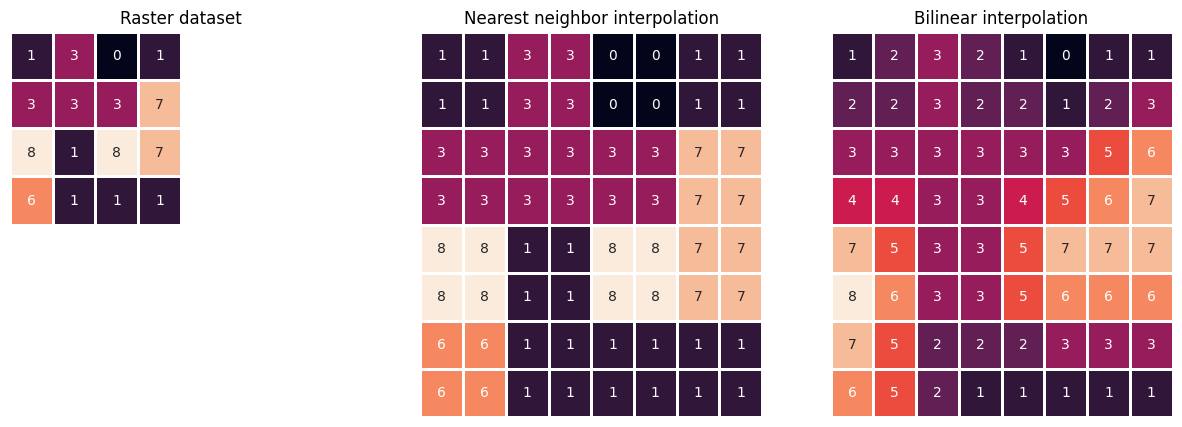

In [4]:
import seaborn as sns


def img_to_heatmap(img, ax, title):  # Magic method to show img as heatmap
    ax.axis("off")
    ax.set_title(title)
    array = np.array(img)
    array = array[None, None, :]
    sns.heatmap(array[0][0], annot=True, ax=ax, lw=1, cbar=False)


# Fake image
raw = np.array([[1, 3, 0, 1], [3, 3, 3, 7], [8, 1, 8, 7], [6, 1, 1, 1]], dtype=np.uint8)
pil = Image.fromarray(raw)

interp_nn = pil.resize((8, 8), resample=Image.NEAREST)
interp_bl = pil.resize((8, 8), resample=Image.BILINEAR)

# Plot result
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
img_to_heatmap(raw, ax[0], "Raster dataset")
img_to_heatmap(interp_nn, ax[1], "Nearest neighbor interpolation")
img_to_heatmap(interp_bl, ax[2], "Bilinear interpolation")
plt.show()

[Билинейная интерполяция 📚[wiki]](https://en.wikipedia.org/wiki/Bilinear_interpolation) позволяет избавиться от резких границ, которые возникают при увеличении методом ближайшего соседа.  Существуют и другие виды интерполяции, использующие большее количество соседних пикселей.

### Upsample в PyTorch

К чему был этот разговор об увеличении картинок?

Оказывается, для увеличения пространственного разрешения карт признаков (feature maps) можно применять те же методы, что и для изображений.

Для увеличения пространственного разрешения карт признаков (карт активаций) в PyTorch используется класс `nn.Upsample` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html). В нём доступны все упомянутые методы интерполяции, а также трилинейная интерполяция — аналог билинейной интерполяции, используемый для работы с трёхмерными пространственными данными (к примеру, видео).

[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html?highlight=interp#torch.nn.functional.interpolate) `torch.nn.functional.interpolate`

Таким образом мы можем использовать `nn.Upsample` внутри разжимающего блока.

Загрузим изображение:

In [5]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_segmentation_1.png -O cat.png

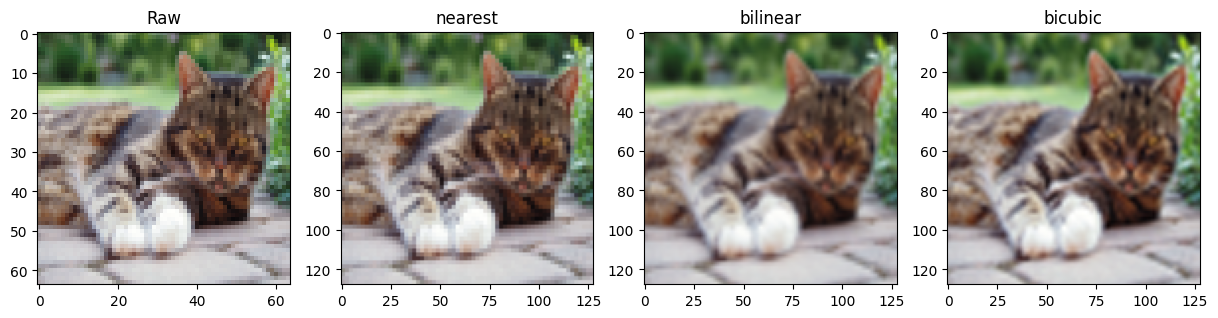

In [6]:
from torch import nn
import torchvision.transforms.functional as TF


def upsample(pil, ax, mode="nearest"):
    tensor = TF.to_tensor(pil)
    # Create upsample instance

    if mode == "nearest":
        upsampler = nn.Upsample(scale_factor=2, mode=mode)
    else:
        upsampler = nn.Upsample(scale_factor=2, mode=mode, align_corners=True)

    tensor_128 = upsampler(tensor.unsqueeze(0))  # add batch dimension
    # Convert tensor to Pillow
    img_128 = tensor_128.squeeze()
    img_128_pil = TF.to_pil_image(img_128.clamp(min=0, max=1))
    ax.imshow(img_128_pil)
    ax.set_title(mode)


# Load and show image in Pillow format
pic = Image.open("cat.png")
pil_64 = pic.resize((64, 64))
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))
ax[0].imshow(pil_64)
ax[0].set_title("Raw")

# Upsample with Pytorch
upsample(pil_64, mode="nearest", ax=ax[1])
upsample(pil_64, mode="bilinear", ax=ax[2])
upsample(pil_64, mode="bicubic", ax=ax[3])
plt.show()

Обратите внимание на то, что в данном случае каждое из пространственных измерений изображения увеличилось в 2 раза, но при необходимости возможно использовать увеличение в иное, в том числе не целое количество раз, используя параметр `scale_factor`.

Слои `nn.Upsample` обычно комбинируют вместе со сверточными, это рекомендованный способ увеличения пространственных размеров карт признаков.

In [7]:
# fmt: off
model = nn.Sequential(
    nn.Upsample(scale_factor=2),
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU()
)
# fmt: on

dummy_input = torch.randn((0, 3, 32, 32))
out = model(dummy_input)
print(out.shape)

torch.Size([0, 16, 64, 64])


### Другие способы "разжать" карту признаков

#### MaxUnpooling

Помимо свёртки, на этапе снижения размерности также используются слои субдискретизации (pooling). Наиболее популярным вариантом является MaxPooling, сохраняющий значение только наибольшего элемента внутри сегмента. Для того, чтобы обратить данную операцию, был предложен слой MaxUnpooling.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/maxunpooling.png" width="650">

Данный слой требует сохранения индексов максимальных элементов внутри сегментов: при обратной операции максимальное значение помещается на место, в котором был максимальный элемент сегмента до соответствующей субдискретизации. Соответственно, каждому слою MaxUnpooling должен соответствовать слой MaxPooling, что визуально можно представить следующим образом:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/downsample_and_upsample_layers.png" width="650">

[[doc] 🛠️](
https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) `torch.nn.MaxPool2d`

[[doc] 🛠️](
https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html?highlight=unpooling) `torch.nn.MaxUnpool2d`

http://images.cocodataset.org/val2017/000000448263.jpg
Orginal shape torch.Size([1, 3, 240, 320])
Downsample shape torch.Size([1, 3, 60, 80])
Upsample shape torch.Size([1, 3, 240, 320])


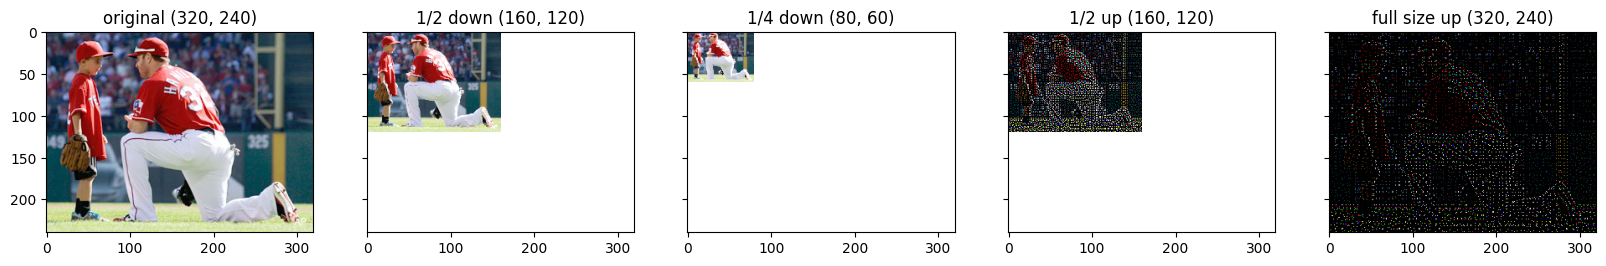

In [8]:
torch.use_deterministic_algorithms(False, warn_only=False)


def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def tensor_show(tensor, title="", ax=ax):
    img = TF.to_pil_image(tensor.squeeze()).convert("RGB")
    ax.set_title(title + str(img.size))
    ax.imshow(img)


pool = nn.MaxPool2d(
    kernel_size=2, return_indices=True
)  # False by default(get indexes to upsample)
unpool = nn.MaxUnpool2d(kernel_size=2)

pil = coco2pil("http://images.cocodataset.org/val2017/000000448263.jpg")

fig, ax = plt.subplots(ncols=5, figsize=(20, 5), sharex=True, sharey=True)

ax[0].set_title("original " + str(pil.size))
ax[0].imshow(pil)
tensor = TF.to_tensor(pil).unsqueeze(0)
print("Orginal shape", tensor.shape)

# Downsample
tensor_half_res, indexes1 = pool(tensor)
tensor_show(tensor_half_res, "1/2 down ", ax=ax[1])

tensor_q_res, indexes2 = pool(tensor_half_res)
tensor_show(tensor_q_res, "1/4 down ", ax=ax[2])
print("Downsample shape", indexes2.shape)

# Upsample
tensor_half_res1 = unpool(tensor_q_res, indexes2)
tensor_show(tensor_half_res1, "1/2 up ", ax=ax[3])


tensor_recovered = unpool(tensor_half_res1, indexes1)
tensor_show(tensor_recovered, "full size up ", ax=ax[4])
print("Upsample shape", tensor_recovered.shape)
plt.show()

#### Transposed convolution

Способы восстановления пространственных размерностей, которые мы рассмотрели, не содержали обучаемых параметров.

Для повышения пространственного разрешения карты признаков можно использовать операцию *Transposed convolution*, в которой, как в обычной свертке, есть **обучаемые параметры**. Альтернативное название: *Fractionally-strided convolution*.

Иногда **некорректно** называется *обратной сверткой* или *Deconvolution*.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/simple_convolution.png" width="700"></center>
<center><em>Обычная свертка</em></center>

Операция обычной свертки накладывает фильтр-ядро на фрагмент карты, выполняет поэлементное умножение, а затем сложение, превращая **один фрагмент** входа в **один пиксель** выхода.

Transposed convolution, наоборот, проходит по всем пикселям входа и умножает их на **обучаемое ядро** свертки. При этом каждый **одиночный пиксель** превращается в **фрагмент**. Там, где фрагменты накладываются друг на друга, значения попиксельно суммируются.

Если вход имеет несколько каналов, то Transposed convolution применяет отдельный обучаемый фильтр к каждому каналу, а результат суммирует.

Параметр `stride` отвечает за дополнительный сдвиг каждого фрагмента на выходе. Используя Transposed convolution с параметром `stride = 2`, можно повышать размер карты признаков приблизительно в два раза, добавляя на нее мелкие детали.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/transposed_convolution_explained.png" width="1024"></center>

<center><em>Transposed convolution</em></center>

В отличие от обычной свертки, параметр `padding` в Transposed convolution отвечает не за добавление "рамки" из нулей по краям изображения/карты признаков для сохранения пространственного разрешения на выходе после свертки, а, наоборот, за удаление внешнего края ("рамки") выходной карты признаков. Это может быть полезно, потому что карта признаков (feature map) строится с перекрытием фрагментов, полученных из соседних пикселей, но по периметру результат формируется без перекрытия и может иметь более низкое качество.

Как правило, размер ядра `kernel_size` выбирают кратным `stride`, чтобы избавиться от артефактов-ложных перемножений промежуточных признаков при частичном наложении фрагментов, например:
```
kernel_size = 4
stride = 2
```
При таких значениях имеет смысл установить `padding=2`, чтобы убрать внешние два пикселя со всех сторон выходной карты признаков, полученные без перекрытия.

[[blog] ✏️ Про 2D свертки с помощью перемножения матриц](https://www.baeldung.com/cs/convolution-matrix-multiplication)

[[arxiv] 🎓 A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285v1.pdf) — откуда слово Transposed в названии (раздел 4.1)

[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=transpose#convtranspose2d) `torch.nn.ConvTranspose2d`

```
torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                         stride=1, padding=0, ...)
```
где:
* `in_channels`, `out_channels` — количество каналов во входной и выходной картах признаков,
* `kernel_size` — размер ядра свертки Transposed convolution,
* `stride` — шаг свертки Transposed convolution,
* `padding`— размер отступов, устанавливаемых по краям входной карты признаков.



Пример использования:

Original size torch.Size([1, 16, 16, 16])
Downsampled size torch.Size([1, 16, 8, 8])
Upsampled size torch.Size([1, 16, 16, 16])


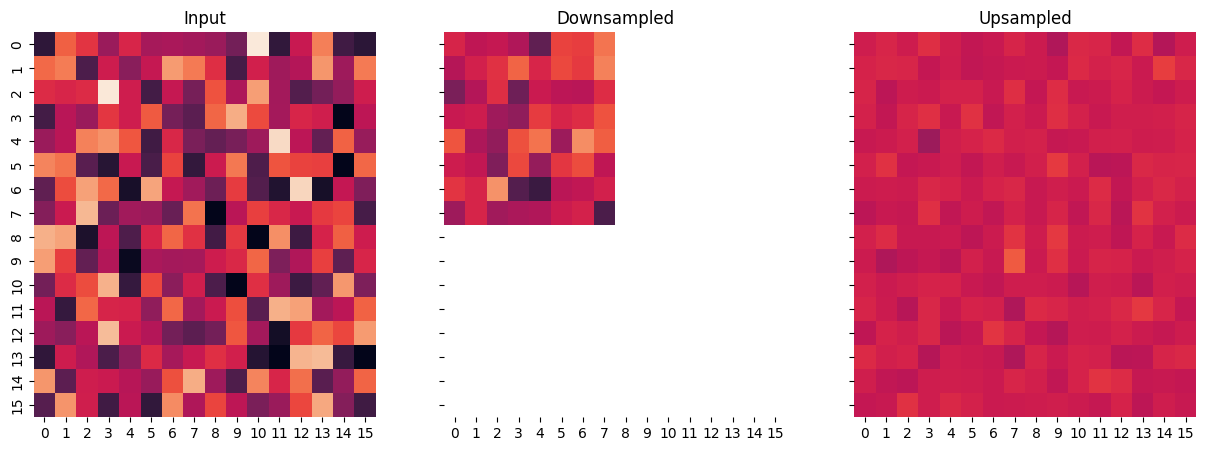

In [9]:
input = torch.randn(1, 16, 16, 16)  # define dummy input
print("Original size", input.shape)

downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)  # define downsample layer
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)  # define upsample layer

# let`s downsample and upsample input
with torch.no_grad():
    output_1 = downsample(input)
    print("Downsampled size", output_1.size())

    output_2 = upsample(output_1, output_size=input.size())
    print("Upsampled size", output_2.size())

# plot results
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
sns.heatmap(input[0, 0, :, :], ax=ax[0], cbar=False, vmin=-2, vmax=2)
ax[0].set_title("Input")
sns.heatmap(output_1[0, 0, :, :], ax=ax[1], cbar=False, vmin=-2, vmax=2)
ax[1].set_title("Downsampled")
sns.heatmap(output_2[0, 0, :, :], ax=ax[2], cbar=False, vmin=-2, vmax=2)
ax[2].set_title("Upsampled")
plt.show()

## Пирамида признаков

Возникает вопрос: не потеряется ли информация о мелких деталях изображения при передаче через центральный блок сети, где пространственное разрешение минимально? Такая проблема существует.

Те, кто изучал классические методы машинного зрения, помнят, что  при извлечении дескрипторов особых точек ([SIFT 📚[wiki]](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform)) использовалась так называемая пирамида изображений.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/pyramid_of_features.png" width="650">

Идея состоит в последовательном уменьшении (масштабировании) изображения и последовательном извлечении признаков в разных разрешениях.

При уменьшении пространственных размеров мы естественным образом получаем карты признаков с разным пространственным разрешением.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_information.png" width="650">

Их можно использовать одновременно как в качестве входа для новых сверток, так и для получения предсказаний.

На этой модели построены FPN-сети.

[[arxiv] 🎓 Feature Pyramid Networks for Object Detection (Lin et al., 2017)](https://arxiv.org/abs/1612.03144)

<img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/fcn_1.png" width="1000">

<center><em>Source: <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf"> Fully Convolutional Networks for Semantic Segmentation</a></em></center>

После того, как все карты признаков будут увеличены до одного размера, они суммируются.

Примеры использования:
* [[doc] 🛠️ Fully-Convolutional Network model with ResNet-50 and ResNet-101 backbones](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)
* [[doc] 🛠️ Models and Pre-trained Weights](https://pytorch.org/vision/stable/models.html#semantic-segmentation)


Модель была предобучена на части датасета COCO train2017 (на 20 категориях, представленных так же в датасете  Pascal VOC). Использовались следующие классы:

`['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']`

In [10]:
import torchvision
from torchvision import transforms


def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


# load resnet50
fcn_model = torchvision.models.segmentation.fcn_resnet50(
    weights="FCN_ResNet50_Weights.DEFAULT", num_classes=21
)

classes = [
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # ImageNet
    ]
)

pil_img = coco2pil("http://images.cocodataset.org/val2017/000000448263.jpg")
input_tensor = transform(pil_img)

with torch.no_grad():
    output = fcn_model(input_tensor.unsqueeze(0))

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:01<00:00, 91.5MB/s]


http://images.cocodataset.org/val2017/000000448263.jpg


Возвращается словарь `output`, в котором по ключу `out` содержится массив со значениями ненормированных вероятностей, соответствующих предсказаниям каждого класса.


output keys:  odict_keys(['out', 'aux'])
out:  torch.Size([1, 21, 240, 320]) Batch, class_num, h, w
output_predictions: torch.Size([240, 320])


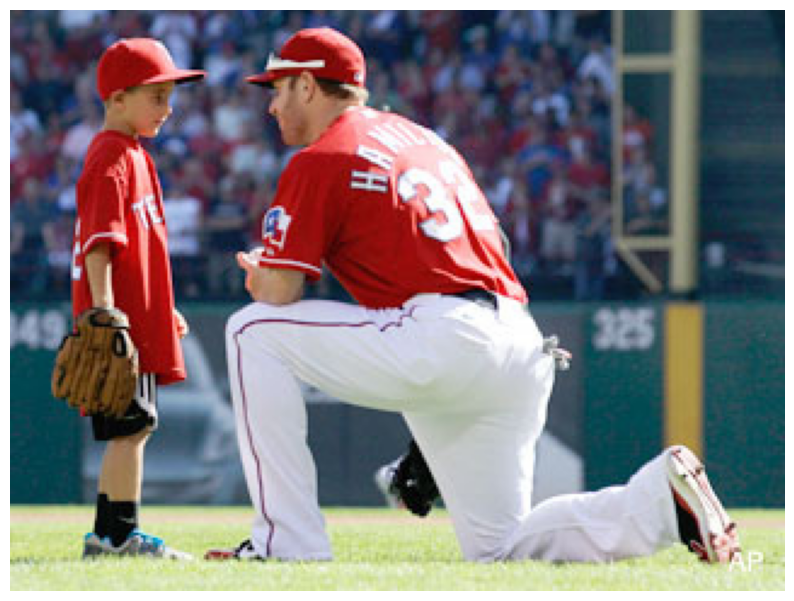

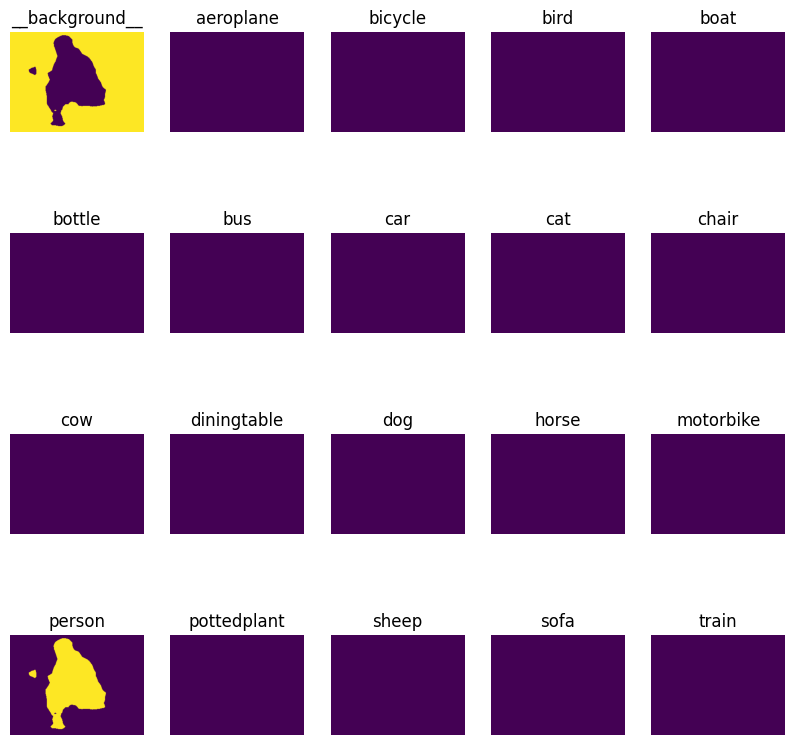

In [11]:
print("output keys: ", output.keys())  # Ordered dictionary
print("out: ", output["out"].shape, "Batch, class_num, h, w")

output_predictions = output["out"][0].argmax(0)  # for first element of batch
print(f"output_predictions: {output_predictions.shape}")

fig = plt.figure(figsize=(10, 10))
plt.imshow(pil_img)
plt.axis("off")
plt.show()

indexes = output_predictions
semantic_seg_person_predict = np.zeros(pil_img.size).astype(bool)

# plot all classes predictions
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10))
i = 0  # counter
for row in range(4):
    for col in range(5):
        mask = torch.zeros(indexes.shape)
        mask[indexes == i] = 255

        ax[row, col].set_title(classes[i])
        ax[row, col].imshow(mask)
        ax[row, col].axis("off")
        i += 1

plt.show()

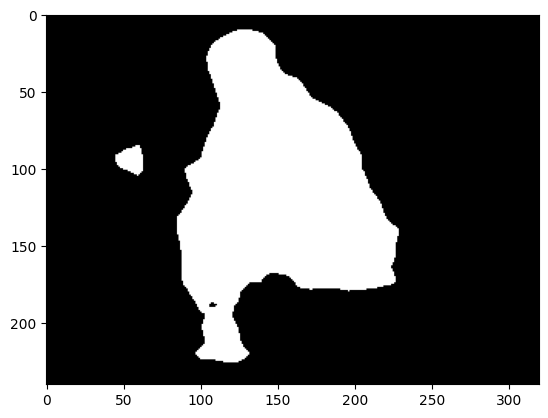

In [12]:
semantic_seg_person_predict = torch.zeros(indexes.shape)
semantic_seg_person_predict[indexes == 15] = 1  # to obtain binary mask by Pascal VOC class id
semantic_seg_person_predict = (
    semantic_seg_person_predict.numpy()
)  # for sklearn compability

plt.imshow(semantic_seg_person_predict, cmap="gray")
plt.show()

##Метрики

### IoU

Как оценить качество предсказаний, полученных от модели?

Базовой метрикой является Intersection over Union (IoU), она же коэффициент Жаккарда ([Jaccard index 📚[wiki]](https://en.wikipedia.org/wiki/Jaccard_index)).

Имеются предсказание модели (фиолетовая маска) и целевая разметка,  сделанная человеком (красная маска)*.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/iou_sample.png" width="400"></center>

<center><em>Source: <a href="https://datahacker.rs/deep-learning-intersection-over-union/">Intersection over Union</a></em></center>

Необходимо оценить качество предсказания.

**Для простоты в примере маски прямоугольные, но та же логика будет работать  для масок произвольной формы.*

Метрика считается как отношение площади пересечения к площади объединения двух масок:

$$ \large \text{IoU} = \frac{|T \cap P|}{|T \cup P|} $$

$T$ — True mask, $P$ — predicted mask.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/iou_formula.png" width="500"></center>

Если маски совпадут на $100\%$, то значение метрики будет равно $1$, и это наилучший результат. При пустом пересечении $\text{IoU} $ будет нулевым. Значения метрики лежат в интервале $[0..1]$.

В терминах ошибок первого/второго рода $\text{IoU}$  можно записать как:

$$ \large \text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}} $$


$\text{TP}$ — True positive — пересечение (обозначено желтым),

$\text{FP}$ — False Positive (остаток фиолетового прямоугольника),

$\text{FN}$ — False Negative (остаток красного прямоугольника).

На базе этой метрики строится ряд производных от нее метрик, таких как Mean Average Precision, которую мы рассмотрим в разделе Детектирование.

[[blog] ✏️ Intersection over Union](http://datahacker.rs/deep-learning-intersection-over-union/)

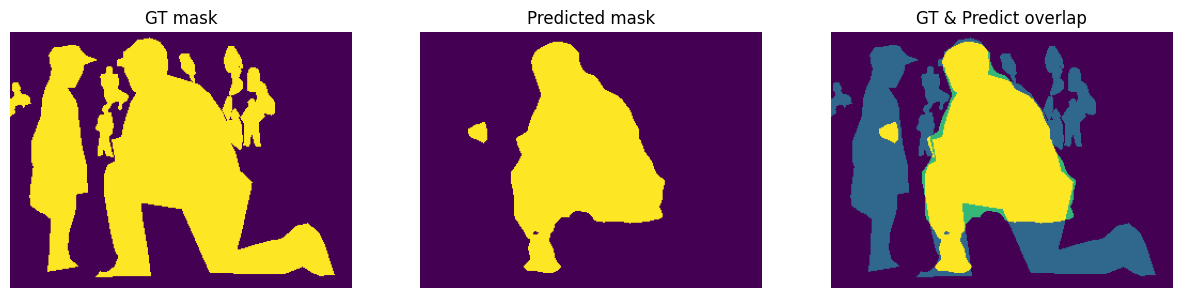

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("GT mask")
plt.imshow(semantic_seg_person_mask)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("Predicted mask")
plt.imshow(semantic_seg_person_predict)

plt.subplot(1, 3, 3)
plt.title("GT & Predict overlap")
plt.axis("off")
tmp = semantic_seg_person_predict * 2 + semantic_seg_person_mask
plt.imshow(tmp)
plt.show()

Реализации:

* [[git] 🐾 Jaccard score в Torchmetrics](https://github.com/Lightning-AI/torchmetrics/blob/8fade87062a7b87c1e6429bbe1c4e0112b3713a5/torchmetrics/functional/classification/jaccard.py)
* [[doc] 🛠️ Jaccard score в Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)
* [[doc] 🛠️ SMP в PyTorch](https://smp.readthedocs.io/en/latest/metrics.html#segmentation_models_pytorch.metrics.functional.iou_score)
* [[doc] 🛠️ Jaccard index between two sets of boxes в Torchvision](https://pytorch.org/vision/main/generated/torchvision.ops.box_iou.html)

In [14]:
from sklearn.metrics import jaccard_score

# accept only vectors, so we have to flatten the data
y_true = semantic_seg_person_mask.flatten()
y_pred = semantic_seg_person_predict.flatten()
iou = jaccard_score(y_true, y_pred)

print(f"IoU = {iou:.2f}")

IoU = 0.49


In [15]:
from sklearn.metrics import confusion_matrix

# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
# or use:  smp.metrics.get_stats
# https://smp.readthedocs.io/en/latest/metrics.html#segmentation_models_pytorch.metrics.functional.get_stats
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
iou = tp / (tp + fp + fn)
print(f"IoU = {iou:.2f}")

IoU = 0.49


### Dice

Другой популярной метрикой для оценки качества сегментации является $\text{Dice}$ коэффициент:

$$ \large \text{Dice} = \dfrac{2|A \cap B|}{|A| + |B|} $$

Концептуально он похож на $\text{IoU}$, но при выражении через ошибки первого и второго рода будет видно, что он совпадет с [F1-мерой 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html):

$$ \large \text{Dice} =  \frac{2|A \cap B|}{|A| + |B|} = \dfrac{2\text{TP}}{2\text{TP} + \text{FP} + \text{FN}} = \text{F1_score} ∈ [0,1]$$

[[blog] ✏️ F1 Score = Dice Coefficient](https://chenriang.me/f1-equal-dice-coefficient.html)

In [16]:
from sklearn.metrics import f1_score

dice_smp = f1_score(y_true, y_pred)
dice = 2 * tp / (2 * tp + fp + fn)
print(f"Dice = {dice:.2f}")
print(f"F1_score = {dice_smp:.2f}")

Dice = 0.65
F1_score = 0.65


Dice vs IoU

Одна метрика выражается через другую:

$Dice = \frac{2\,\mathrm{IoU}}{1+\mathrm{IoU}}, \qquad \mathrm{IoU} = \frac{\mathrm{Dice}}{2-\mathrm{Dice}}$
 
 минимум и макксимум - совпадают


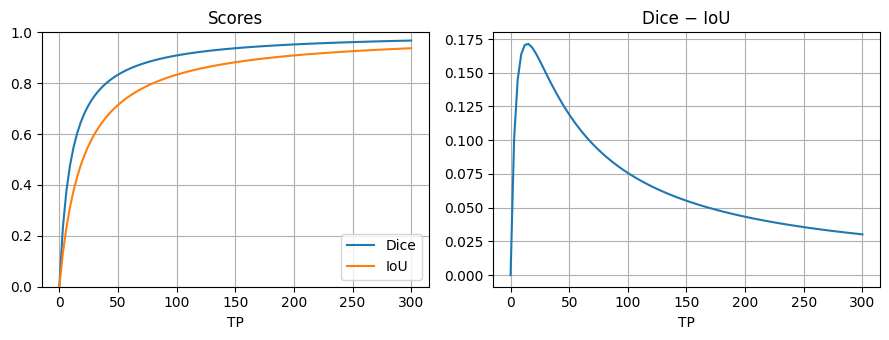

In [17]:
import numpy as np
import matplotlib.pyplot as plt

tp = np.linspace(0, 300, 100); fp_fn = 20.0
dice = (2*tp) / (2*tp + fp_fn)
iou  = tp / (tp + fp_fn)
diff = dice - iou

fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(9, 3.5), sharex=True)
ax0.plot(tp, diff); ax0.set_title("Dice − IoU"); ax0.set_xlabel("TP"); ax0.grid(True)
ax1.plot(tp, dice, label="Dice"); ax1.plot(tp, iou, label="IoU")
ax1.set_title("Scores"); ax1.set_xlabel("TP"); ax1.set_ylim(0, 1); ax1.grid(True); ax1.legend()
plt.tight_layout(); plt.show()

Как видно, IoU строже (сильнее “штрафует” за FP/FN). Поэтому при **малых объектах** (трещины в деталях, сосуды или опухоли на мед. изображениях) — часто предпочитают **Dice**, т.к. добавление TP (верных пикселей) быстрее повышает Dice, чем IoU, особенно когда TP мал.

[[blog] ✏️ All the segmentation metrics!](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics)

## Loss функции для сегментации

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/loss_overview.png" width="900"></center>

<center><em>Source: <a href="https://github.com/JunMa11/SegLoss"> Loss functions for image segmentation </a></em></center>

### Distribution-based loss

Так как задача сегментации сводится к задаче классификации, то можно использовать Cross-Entropy Loss, BCE или Focal Loss, с которыми мы знакомы.

#### Binary Cross-Entropy (BCE)

Если предсказывается маска для объектов единственного класса (`target.shape` = 1×H×W), то задача сводится к бинарной классификации, так как каждый канал на выходе последнего слоя выдает предсказание для единственного класса.

Это позволяет заменить Softmax в Cross-Entropy Loss на сигмоиду, а функцию потерь — на бинарную кросс-энтропию (BCE).

In [18]:
import torch

mask_class_1 = torch.randint(0, 2, (1, 64, 64))  # [0, 1]
one_class_out = torch.randn(1, 1, 64, 64)
print(mask_class_1.shape)
print(one_class_out.shape)

torch.Size([1, 64, 64])
torch.Size([1, 1, 64, 64])


Применяем [BCE with Logits Loss 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html):

In [19]:
from torch import nn

bce_loss_wl = nn.BCEWithLogitsLoss()  # Sigmoid inside
loss = bce_loss_wl(
    one_class_out, mask_class_1.float().unsqueeze(0)
)  # both params must have equal size
print(loss)

tensor(0.7985)


Если последний слой модели — это Сигмоида, то можем использовать [BCE Loss 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html):

In [20]:
norm_one_class_out = one_class_out.sigmoid()

bce_loss = nn.BCELoss()
loss = bce_loss(
    norm_one_class_out, mask_class_1.float().unsqueeze(0)
)  # both params must have equal size
print(loss)

tensor(0.7985)


[Cross-Entropy Loss 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) для одного класса работать не будет:

In [21]:
cross_entropy = nn.CrossEntropyLoss()
loss = cross_entropy(one_class_out, mask_class_1.float().unsqueeze(0))
print(loss)

tensor(-0.)


Так как Softmax от единственного входа всегда равен $1$.

In [22]:
one_class_out.softmax(dim=1).unique()

tensor([1.])

Эту проблему можно решить искусственно, добавив в маску второй класс фона (background) отдельным каналом. Иными словами, для использования `CrossEntropyLoss` с `Softmax` в конце архиектуры нужно сделать One hot encoding одноканальной маски [OHE 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html). Тем самым, задача примет вид Multiclass.

**Multilabel**

Если предсказываются несколько классов и `target` имеет форму N×W×H (multilabel), где N — количество классов, то маска каждого хранится в отдельном канале:



<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_mask2.png" width="600"></center>

<center><em>Source: <a href="https://www.jeremyjordan.me/semantic-segmentation/"> An overview of semantic image segmentation </a></em></center>

In [23]:
mask_class1 = torch.randint(0, 2, (1, 64, 64))  # [0 , 1]
mask_class2 = torch.randint(0, 2, (1, 64, 64))

target = torch.cat((mask_class1, mask_class2))

print(target.shape)

torch.Size([2, 64, 64])


Видим, что форма выхода модели совпадает с формой тензора масок:

In [24]:
two_class_out = torch.randn(1, 2, 64, 64)
print(two_class_out.shape)

torch.Size([1, 2, 64, 64])


Мы можем посчитать [BCE 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) поэлементно, предварительно преобразовав `target` во `float`:

In [25]:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

bce_loss = nn.BCEWithLogitsLoss()  # Sigmoid inside
float_target = target.float()  # add batch and convert ot float
loss = bce_loss(
    two_class_out, float_target.unsqueeze(0)
)  # both params must have equal size
print(loss)

tensor(0.8097)


Или [Cross-Entropy Loss 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):

In [26]:
cross_entropy = nn.CrossEntropyLoss()
# If containing class probabilities, same shape as the input and each value should be between [0,1][0,1].
loss = cross_entropy(two_class_out, float_target.unsqueeze(0))
print(loss)

tensor(0.9002)


Результаты не совпадают, так как после Sigmoid и Softmax получаются разные вероятности.



#### Cross-Entropy

Если маска задана одним каналом, в котором классы пронумерованы целыми числами (multiclass):

In [27]:
sq_target = target.argmax(0)
sq_target.shape

torch.Size([64, 64])

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/semantic_mask1.png" width="900"></center>

<center><em>Source: <a href="https://www.jeremyjordan.me/semantic-segmentation/"> An overview of semantic image segmentation </a></em></center>

То логично использовать `nn.CrossEntropyLoss`:

```
Input: Shape (C), (N,C) or (N,C,d1​,d2​,...,dK​) with K≥1 in the case of K-dimensional loss.

Target: If containing class indices, shape (), (N) or (N,d1,d2,...,dK)
```


In [28]:
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
cross_entropy = nn.CrossEntropyLoss()

loss = cross_entropy(two_class_out, sq_target.unsqueeze(0))
print(loss)

tensor(0.9059)


**Различия Multilabel и Multiclass**

Важно отметить, что помимо способа хранения/записи масок, режим multilabel подразумевает возможность принадлежности одного пикселя сразу нескольким классам, т. е. пересечение классов, что недопустимо в режиме multiclass.

Таким образом, задача Multilabel является более сложной для нейросети. В библитеке Segmentation models PyTorch, рассматриваемой ниже, в функциях потерь для сегментации уже реализованы режимы **Binary, Multilabel и Multiclass** [SMP Losses 🛠️[doc]](https://segmentation-models-pytorch.readthedocs.io/en/latest/losses.html).

### Region-based loss

К Region-based loss относятся функции потерь, основанные на оценке площади пересечения масок.




#### Jaccard Loss

В отличие от accuracy, рассчет IoU (Jaccard index):

$\large \text{IoU} = \text{JaccardIndex} = \dfrac{  TP  }{TP + FP + FN} \in [0,1]$

можно произвести [дифференцируемым образом 🎓[arxiv]](https://arxiv.org/abs/1908.03851).

Для этого нужно применить к предсказаниям функцию Sigmoid, а операцию пересечения заменить поэлементным умножением:

$$ \large \text{IoU} = \frac{|A \cap B|}{|A \cup B|} $$



$ |A \cap B| =
\begin{bmatrix}
0.01 & 0.03 & 0.02 & 0.02 \\ 0.05 & 0.12 & 0.09 & 0.07 \\ 0.89 & 0.85 & 0.88 & 0.91 \\ 0.99 & 0.97 & 0.95 & 0.97 \end{bmatrix} * \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{bmatrix}
\xrightarrow{\ element-wise \ multiply \ } \begin{bmatrix}
0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0.89 & 0.85 & 0.88 & 0.91 \\ 0.99 & 0.97 & 0.95 & 0.97 \end{bmatrix} \xrightarrow{\ sum \ } 7.41$

$\qquad \qquad \qquad \qquad \text{prediction} \qquad \qquad \qquad \quad \text{target}$





$ |A| =
\begin{bmatrix}
0.01 & 0.03 & 0.02 & 0.02 \\ 0.05 & 0.12 & 0.09 & 0.07 \\ 0.89 & 0.85 & 0.88 & 0.91 \\ 0.99 & 0.97 & 0.95 & 0.97 \end{bmatrix}
\xrightarrow{\ sum \ }  7.82 \qquad \qquad|B| =
\begin{bmatrix}
0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{bmatrix} \xrightarrow{\ sum \ }  8 $

$|A \cup B| = |A +B - A  \cap B|$

И тогда метрику можно превратить в функцию потерь, инвертировав ее:

$\large \text{Jaccard Loss} = 1 - \text{IoU}$


В PyTorch такой loss не реализован, поэтому для его использования установим библиотеку [SMP 🐾[git]](https://github.com/qubvel/segmentation_models.pytorch).

In [29]:
!pip install -q segmentation-models-pytorch

clear_output()

In [30]:
import segmentation_models_pytorch as smp

iou_loss = smp.losses.JaccardLoss(smp.losses.MULTILABEL_MODE, from_logits=True) # from_logits mean no Sigmoid defore loss
print("IoU Loss", iou_loss(two_class_out, float_target.unsqueeze(0)))

IoU Loss tensor(0.6693)


* При наличии на выходе модели сигмоиды или softmax, параметр `from_logits` следует устaновить равным `False`.

#### Dice loss

Аналогично можно посчитать Dice коэффициент:

$$ \large \text{Dice} = \dfrac{2|A \cap B|}{|A| + |B|} $$





$$ \large \text{Dice} = \frac{2 \sum\limits_\text{pixels}y_\text{true}y_\text{pred}}{\sum\limits_\text{pixels}y_\text{true} + \sum\limits_\text{pixels}y_\text{pred}}$$

И затем превратить в функцию потерь:

$$ \large \text{DiceLoss} = 1 - \text{Dice} = 1 - \dfrac{2\sum\limits_\text{pixels}y_\text{true}y_\text{pred}}{\sum\limits_\text{pixels}y_\text{true} + \sum\limits_\text{pixels}y_\text{pred}} $$



Эта функция потерь также отсутствует в PyTorch, поэтому воспользуемся библиотекой [SMP 🐾[git]](https://github.com/qubvel/segmentation_models.pytorch).

In [31]:
dice_loss = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)

print(two_class_out.shape, target.shape)
print("DICE Loss", dice_loss(two_class_out, float_target.unsqueeze(0)))

torch.Size([1, 2, 64, 64]) torch.Size([2, 64, 64])
DICE Loss tensor(0.5029)


Концептуально Dice Loss и Jaccard Loss похожи. Но Jaccard Loss [сильнее штрафует модель на выбросах ✏️[blog]](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou).






### Другие loss функции для сегментации и их различия

Основная часть функций потерь, относящихся к типам Region-based и Distribution-based, для задач семантической сегментации реализована в [SMP Losses 🛠️[doc]](https://segmentation-models-pytorch.readthedocs.io/en/latest/losses.html). Отметим некоторые эмпирические соображения:

* Все Distribution-based losses представляют собой производные от cross entropy loss, что зачастую позволяет модели более стабильно обучаться.

* Region-based losses являются дифференцируемыми аналогами основных метрик для оценки качества сегментации, поэтому использование их при обучении обеспечивает максимизацию нужных нам метрик, а именно Dice, IoU.

* На практике, для обеспечения преимуществ каждого из типов функций потерь, их часто используют в линейной комбинации (Compound Loss):
$$ \text{SegLoss} = \beta\times \text{RegionBasedLoss} + (1-\beta) \times \text{DistributionBasedLoss},  \quad \beta \in [0,1],$$
при этом обычно весовой коэффициент $\beta$ задают небольшим, отдавая приоритет DistributionBasedLoss.

* Существуют также Boundary-based segmentation losses. Они используются при необходимости сохранить наиболее точные границы областей при сегментации, но на практике используются редко.  

Хороший обзор функций потерь для семантической сегментации можно найти в [Loss functions for image segmentation 🐾[git]](https://github.com/JunMa11/SegLoss).

## U-Net: Convolutional Networks for Biomedical Image Segmentation

Можно спроектировать сеть так, что карты признаков на выходе сжимающих и соответствующих им разжимающих блоков будут иметь одинаковый размер.

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/efficient_way_predict_pixel_class.png" width="800">

Признаки, полученные при сжатии, скопируем и объединим с признаками в разжимающих слоях, где карты признаков имеют соответствующее пространственное разрешение:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/add_skip_connection.png" width="650">

Так же, как и в ResNet, этот механизм носит название skip connection, но  признаки  не суммируются, а **конкатенируются**.

Рассмотренная нами схема используется в U-Net. Эта популярная модель для сегментации медицинских изображений изначально была предложена в [статье 🎓[arxiv]](https://arxiv.org/abs/1505.04597) для анализа  медицинских изображений.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/unet_scheme.png" width="700"></center>

<center><em>Архитектура U-Net</em></center>

<center><em>Source: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation (Ronneberger et al., 2015)</a></em></center>

[[git] 🐾 Реализация на PyTorch](https://github.com/milesial/Pytorch-UNet)

[[doc] 🛠️ U-Net на PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

Стоит обратить особое внимание на серые стрелки на схеме: они соответствуют операции конкатенации копий ранее полученных карт активаций по аналогии с DenseNet. Чтобы это было возможно, необходимо поддерживать соответствие между размерами карт активаций в процессах снижения и повышения пространственных размерностей. Для этой цели изменения размеров происходят только при операциях `MaxPool` и `MaxUnpool` — в обоих случаях в два раза.

В коде прямой проход может быть реализован, например, вот так:

```
def forward(self, x):
    out1 = self.block1(x) #  ------------------------------>
    out_pool1 = self.pool1(out1)

    out2 = self.block2(out_pool1)
    out_pool2 = self.pool2(out2)

    out3 = self.block3(out_pool2)
    out_pool3 = self.pool2(out3)

    out4 = self.block4(out_pool3)
    # return up
    out_up1 = self.up1(out4)

    out_cat1 = torch.cat((out_up1, out3), dim=1)
    out5 = self.block5(out_cat1)
    out_up2 = self.up2(out5)

    out_cat2 = torch.cat((out_up2, out2), dim=1)
    out6 = self.block6(out_cat2)
    out_up3 = self.up3(out6)

    out_cat3 = torch.cat((out_up3, out1), dim=1) # <-------
    out = self.block7(out_cat3)

    return out

```
После Upsample-блоков ReLU не используется.

## Обзор DeepLabv3+ (2018)

DeepLab — семейство моделей для сегментации, значительно развивавшееся в течение четырёх лет. Основой данного рода моделей является использование **atrous (dilated) convolutions** и, начиная со второй модели, **atrous spatial pyramid pooling**, опирающейся на **spatial pyramid pooling**.

[[arxiv] 🎓 Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Chen et al., 2018)](https://arxiv.org/abs/1802.02611v3)

[[doc] 🛠️ Реализация на PyTorch](https://pytorch.org/vision/stable/models.html#deeplabv3)

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L11/deeplabv3_scheme.png" width="800"></center>

<center><em>Source: <a href="https://www.researchgate.net/publication/339754839_Semantic_Image_Segmentation_with_Deep_Convolutional_Neural_Networks_and_Quick_Shift">Semantic Image Segmentation with DeepConvolutional Neural Networks and Quick Shift</a></em></center>

### Atrous (Dilated) Convolution

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L11/out/dilated_convolution.png" width="650">

**Dilated convolution** (расширенная свертка) — это тип свертки, который "раздувает" ядро, как бы вставляя отверстия между элементами ядра, т. е. делает его разреженным. Дополнительный параметр `dilation` указывает, насколько сильно расширяется ядро.

Фактически в такой свертке входные пиксели (признаки) участвуют через один (два, три ...). Параметр `dilation` указывает, какой по счету пиксель брать про свертке с ядром: при `dilation = 1` — каждый первый, при `dilation = 2` — каждый второй и т. д.

Расширенные свертки позволяют значительно увеличить рецептивное поле и хорошо показывают себя при [решении задач семантической сегментации изображений 🎓[arxiv]](https://arxiv.org/pdf/1511.07122.pdf).


```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
                padding=0, dilation=1, ...)
```
где:
* `in_channels`, `out_channels` — количество каналов во входной и выходной картах признаков,
* `kernel_size` — размер ядра свертки,
* `stride` — шаг свертки,
* `padding` — размер отступов, устанавливаемых по краям входной карты признаков,
* `dilation` — скорость расширения свертки.

[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) `nn.Conv2d`